In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt 

# Clean sounds

## Single identification and localization

Several architectures can be comparated using random optimization

In [2]:
from nideep.eval.eval_utils import Phase
from nideep.eval.learning_curve import LearningCurve

metric_names = ["max_test_accuracy", \
                "mean_test_accuracy", \
                "min_test_loss", \
                "mean_test_loss", \
                "test_train_diff"]

def name_folder(batch):
    return '/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/' + batch

def name_metric(metric, task):
    return metric + '_' + task

def summary(log, tasks, metric_names):
    """Important metrics on log"""
    s = {}
    e = LearningCurve(log)
    e.parse()
    
    for task in tasks:
        train_num = e.list('NumIters', Phase.TRAIN)
        test_num = e.list('NumIters', Phase.TEST)
        train_loss = e.list(name_metric('loss', task), Phase.TRAIN)
        train_loss = np.array([train_loss[np.abs(train_num - i[0]).argmin()] for i in test_num]) # adjusted to test phase
        test_loss = e.list(name_metric('loss', task), Phase.TEST)
        test_accuracy = e.list(name_metric('accuracy', task), Phase.TEST)
        plateau = int(len(test_num) * .25) + 1 # last 25% of test phase

        max_test_accuracy = np.max(test_accuracy)
        mean_test_accuracy = np.mean(test_accuracy[-plateau:])
        min_test_loss = np.min(test_loss)
        mean_test_loss = np.mean(test_loss[-plateau:])
        test_train_diff = np.min(np.absolute(train_loss - test_loss) / np.maximum(train_loss, test_loss))
        
        s[task] = {}
        for metric_name in metric_names:
            s[task][metric_name] = eval(metric_name)

    return s

def summaries(logs, tasks, metric_names):
    """Aggregate all summaries from logs"""
    # dic initialization
    ss = {}
    for task in tasks:
        ss[task] = {}
        for metric_name in metric_names:
            ss[task][metric_name] = []
    # fill the dic with summary reports from all logs
    for log in logs:
        s = summary(log, tasks, metric_names)
        for task in tasks:
            for metric_name in metric_names:
                ss[task][metric_name].append(s[task][metric_name])
    return ss

def name_logs(batch, numbers):
    """Produce paths to logs for repository 'batch' and specified numbers"""
    return [name_folder(batch) + '/logs/caffe' + str(i) for i in numbers]

logs = name_logs('random-optimization-twoconvtwoip', [0, 1])
tasks = ['classification', 'localization']

#summary(logs[0], tasks, metric_names)
#summaries(logs, tasks, metric_names)

In [3]:
def get_good_logs(batch, task='classification', threshold_inf=0.5, threshold_max = 1.0, print_=True):
    """Lists all logs with valid networks"""
    logs = name_logs(batch, range(100))
    good_logs = []
    for log in logs:
        if os.path.isfile(log):
            e = LearningCurve(log)
            e.parse()
            test_accuracy = e.list(name_metric('accuracy', task), Phase.TEST)
            try:
                if test_accuracy[-1, 0] > threshold_inf and test_accuracy[-1, 0] < threshold_max:
                    good_logs.append(log)
            except:
                pass
    if print_:
        print "For", batch, len(good_logs), "valid logs were found"
    return good_logs

In [4]:
logs_oneconvtwoip = get_good_logs('random-optimization-oneconvtwoip', task='classification', threshold_inf=0.73, threshold_max=1)
logs_twoconv = get_good_logs('random-optimization-twoconv', task='classification', threshold_inf=0.75)
logs_threeconv = get_good_logs('random-optimization-threeconv', task='classification', threshold_inf=0.73)
logs_twoconvtwoip = get_good_logs('random-optimization-twoconvtwoip', task='classification', threshold_inf=0.73)
logs_oneconvtwoip2 = get_good_logs('random-optimization-oneconvtwoip2', task='classification', threshold_inf=0.73, threshold_max=1)
logs_allfeatures = get_good_logs('random-optimization-allfeatures', task='classification', threshold_inf=0.73)
logs_allfeaturestwoip = get_good_logs('random-optimization-allfeaturestwoip', task='classification', threshold_inf=0.73)
logs_allfeatures2 = get_good_logs('random-optimization-allfeatures2', task='classification', threshold_inf=0.73)

s_oneconvtwoip = summaries(logs_oneconvtwoip, tasks, metric_names)
s_twoconv = summaries(logs_twoconv, tasks, metric_names)
s_threeconv = summaries(logs_threeconv, tasks, metric_names)
s_twoconvtwoip = summaries(logs_twoconvtwoip, tasks, metric_names)
s_oneconvtwoip2 = summaries(logs_oneconvtwoip2, tasks, metric_names)
s_allfeatures = summaries(logs_allfeatures, tasks, metric_names)
s_allfeaturestwoip = summaries(logs_allfeaturestwoip, tasks, metric_names)
s_allfeatures2 = summaries(logs_allfeatures2, tasks, metric_names)

For random-optimization-oneconvtwoip 39 valid logs were found
For random-optimization-twoconv 21 valid logs were found
For random-optimization-threeconv 25 valid logs were found
For random-optimization-twoconvtwoip 24 valid logs were found
For random-optimization-oneconvtwoip2 43 valid logs were found
For random-optimization-allfeatures 32 valid logs were found
For random-optimization-allfeaturestwoip 4 valid logs were found
For random-optimization-allfeatures2 33 valid logs were found


max_test_accuracy


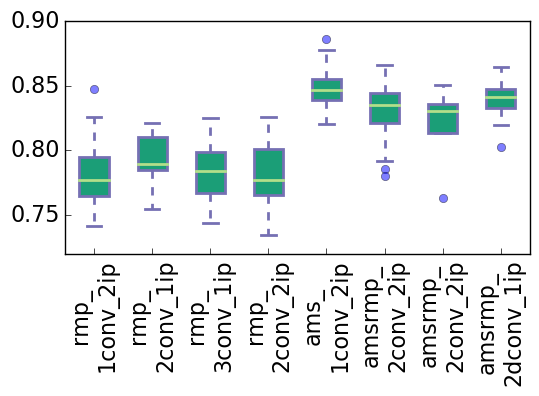

mean_test_accuracy


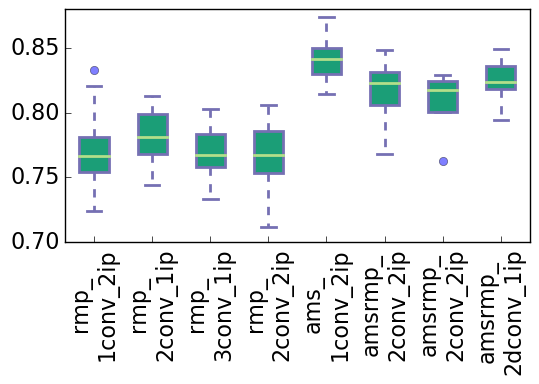

min_test_loss


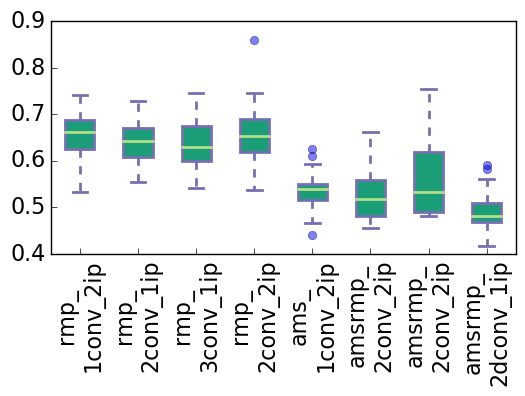

mean_test_loss


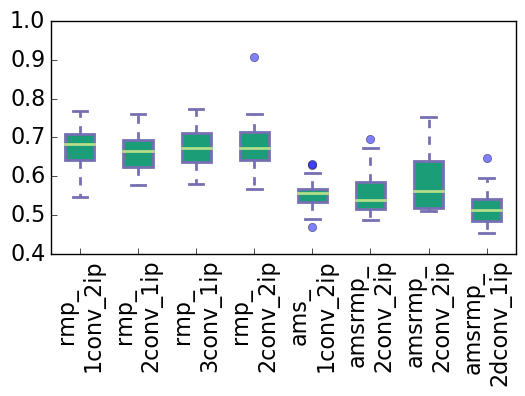

test_train_diff


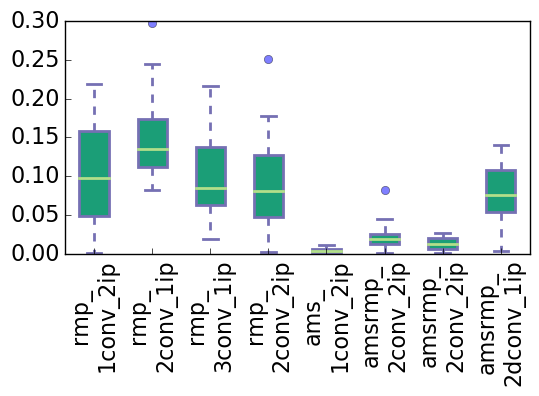

In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16, 'text.usetex': False})

metric_name = "max_test_accuracy"
task = "classification"

for metric_name in metric_names:
    print metric_name
    # Boxplots
    fig = plt.figure(1, figsize=(6, 3))
    ax = fig.add_subplot(111)
    bp = ax.boxplot([s_oneconvtwoip[task][metric_name], \
                     s_twoconv[task][metric_name], \
                     s_threeconv[task][metric_name], \
                     s_twoconvtwoip[task][metric_name], \
                     s_oneconvtwoip2[task][metric_name], \
                     s_allfeatures[task][metric_name], \
                     s_allfeaturestwoip[task][metric_name], \
                     s_allfeatures2[task][metric_name]], \
                    patch_artist=True)
    # Layout
    for box in bp['boxes']:
        box.set(color='#7570b3', linewidth=2)
        box.set(facecolor = '#1b9e77')
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)
    # Legend
    ax.set_xticklabels(['rmp_\n1conv_2ip', 'rmp_\n2conv_1ip', 'rmp_\n3conv_1ip', 'rmp_\n2conv_2ip', 'ams_\n1conv_2ip', 'amsrmp_\n2conv_2ip', 'amsrmp_\n2conv_2ip', 'amsrmp_\n2dconv_1ip'], rotation='vertical')
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.savefig(name_folder(metric_name))
    plt.show()

In [ ]:
# Best oneconv model in mean_test_accuracy
accuracies_oneconvtwoip = s_oneconvtwoip['classification']['mean_test_accuracy']
best_accuracies, best_logs = (list(t) for t in zip(*sorted(zip(accuracies_oneconvtwoip, logs_oneconvtwoip), reverse=True)))

print "Best mean accuracy:", best_accuracies[0]
print "Best net architecture:", best_logs[0].split("/")[-1]
print ""

#with open(best_logs[0], 'r') as f:
#    for line in f.readlines():
#        if line[0] <> "I":
#            print line[:-1]

In [13]:
# Best twoconv model in mean_test_accuracy
accuracies_twoconv = s_twoconv['classification']['mean_test_accuracy']
best_accuracies, best_logs = (list(t) for t in zip(*sorted(zip(accuracies_twoconv, logs_twoconv), reverse=True)))

print "Best mean accuracy:", best_accuracies[0]
print "Best net architecture:", best_logs[0].split("/")[-1]
print ""

Best mean accuracy: 0.813145833333
Best net architecture: caffe42



In [18]:
# Best oneconvtwoip2 model in mean_test_accuracy
accuracies_oneconvtwoip2 = s_oneconvtwoip2['classification']['mean_test_accuracy']
best_accuracies, best_logs = (list(t) for t in zip(*sorted(zip(accuracies_oneconvtwoip2, logs_oneconvtwoip2), reverse=True)))

print "Best mean accuracy:", best_accuracies[0]
print "Best net architecture:", best_logs[0].split("/")[-1]
print ""

Best mean accuracy: 0.873974
Best net architecture: caffe30



## Which task is to be trained first?

In [7]:
import matplotlib
from matplotlib import rc
matplotlib.rcParams.update({'font.size': 16, 'text.usetex': False})

# FONCTION A REFAIRE
def get_plateau(log, task):
    e = LearningCurve(log)
    e.parse()
    
    test_num = e.list('NumIters', Phase.TEST)
    test_accuracy = e.list(name_metric('accuracy', task), Phase.TEST)
    plateau = int(len(test_num) * .25) + 1 # last 25% of test phase
    final_mean = np.mean(test_accuracy[-plateau:])
    
    for n, it in enumerate(test_num[:-plateau]):
        current_mean = np.mean(test_accuracy[n:n + plateau])
        if current_mean > 0.98 * final_mean or current_mean < 1.02 * final_mean:
            return it
    return it

In [8]:
def concat_logs(logs, tasks):
    s = {}
    for task in tasks:
        s[task] = {}
        s[task]['train_num'] = []
        s[task]['test_num'] = []
        s[task]['train_loss'] = []
        s[task]['test_loss'] = []
        s[task]['test_accuracy'] = []
    for it, log in enumerate(logs):
        print log
        e = LearningCurve(log)
        e.parse()
        for task in tasks:
            if it == 0:
                ajout_train = 0
                ajout_test = 0
            else:
                ajout_train = s[task]['train_num'][-1]
                ajout_test = s[task]['test_num'][-1]
            s[task]['train_num'].extend(np.squeeze(e.list('NumIters', Phase.TRAIN) + ajout_train).tolist())
            s[task]['test_num'].extend(np.squeeze(e.list('NumIters', Phase.TEST) + ajout_test).tolist())
            s[task]['train_loss'].extend(np.squeeze(e.list(name_metric('loss', task), Phase.TRAIN)).tolist())
            s[task]['test_loss'].extend(np.squeeze(e.list(name_metric('loss', task), Phase.TEST)).tolist())
            s[task]['test_accuracy'].extend(np.squeeze(e.list(name_metric('accuracy', task), Phase.TEST)).tolist())
    return s

In [9]:
logs = ['/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparison/logs/IDloc2',
        '/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparisontry/logs/idLOC2',
        '/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparisontry/logs/idLOC3']
idloc = concat_logs(logs, tasks)

logs = ['/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparison2/logs/LOCid1',
        '/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparison2/logs/LOCid2',
        '/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparison2/logs/locID1',
        '/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparison2/logs/locID2']
locid = concat_logs(logs, tasks)

logs = ['/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_joint/logs/joint1',
        '/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_joint/logs/joint2']
joint = concat_logs(logs, tasks)

logs = ['/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_joint2/logs/joint1',
        '/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_joint2/logs/joint2']
joint2 = concat_logs(logs, tasks)

/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparison/logs/IDloc2
/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparisontry/logs/idLOC2
/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparisontry/logs/idLOC3
/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparison2/logs/LOCid1
/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparison2/logs/LOCid2
/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparison2/logs/locID1
/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_comparison2/logs/locID2
/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_joint/logs/joint1
/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_joint/logs/joint2
/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/clean_joint2/logs/joint1
/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models

In [10]:
def moving_avg(x, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(x, window, 'valid')

In [11]:
# Shorten
for unit in ['train_num', 'test_num', 'train_loss', 'test_loss', 'test_accuracy']:
    locid['localization'][unit] = locid['localization'][unit][:len(joint['localization'][unit])]
    idloc['classification'][unit] = idloc['classification'][unit][:len(joint['classification'][unit])]

LOCALIZATION TEST (LOSS)


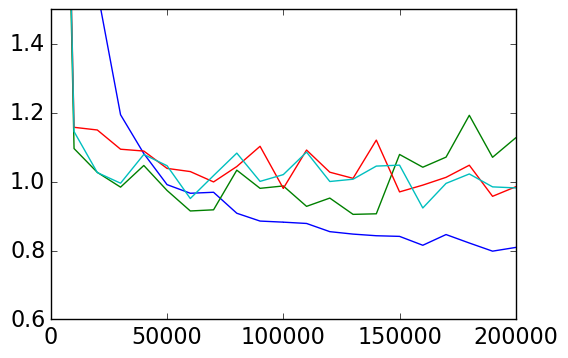

LOCALIZATION TEST (ACCURACY)


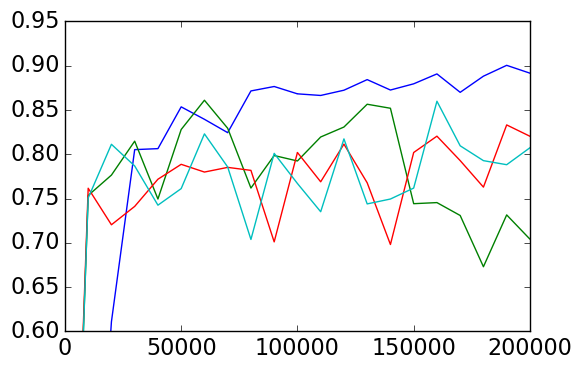

LOCALIZATION TRAIN (LOSS)


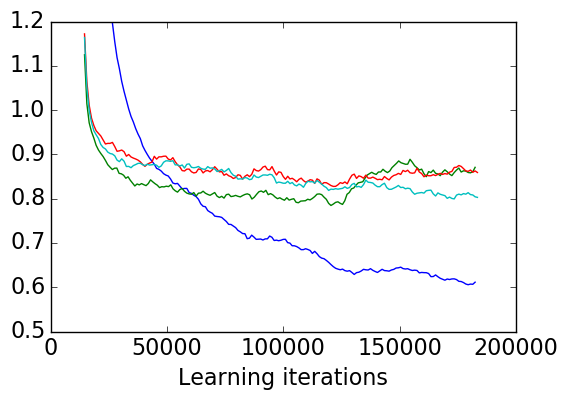

IDENTIFICATION TEST (LOSS)


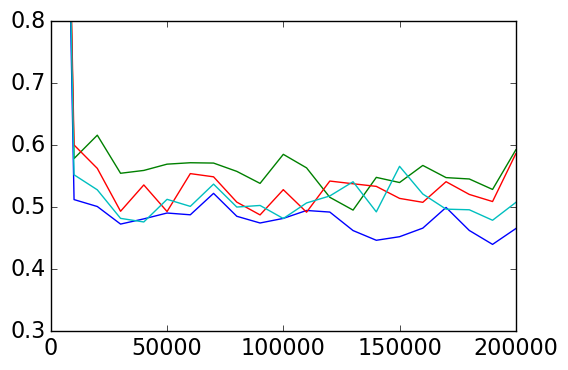

IDENTIFICATION TEST (ACCURACY)


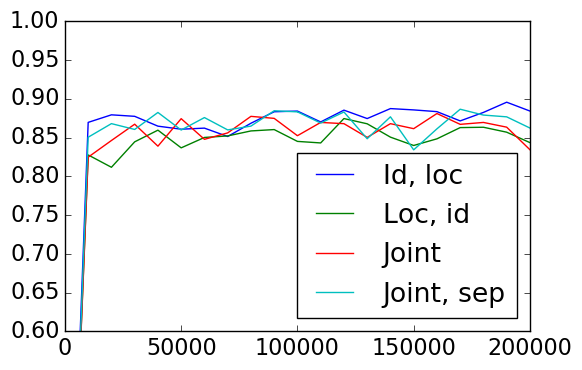

IDENTIFICATION TRAIN (LOSS)


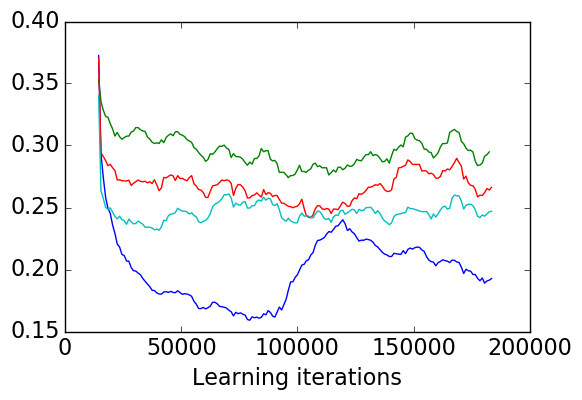

In [15]:
# Un graphique par tache et par phase ou on superpose tous les modes
idloc_label = 'Id, loc'
locid_label = 'Loc, id'
joint_label = 'Joint'
joint2_label = 'Joint, sep'

# LOCALIZATION TEST (LOSS)
task = 'localization'
metrics = 'test_loss'
unit = 'test_num'
print 'LOCALIZATION TEST (LOSS)'
plt.plot([i - 100000 for i in idloc[task][unit][10:]], idloc[task][metrics][10:], label=idloc_label)
plt.plot(locid[task][unit], locid[task][metrics], label=locid_label)
plt.plot(joint[task][unit], joint[task][metrics], label=joint_label)
plt.plot(joint2[task][unit], joint2[task][metrics], label=joint2_label)
axes = plt.gca()
axes.set_ylim([0.6,1.5])
axes.set_xlim([0,200000])
plt.show()

# LOCALIZATION TEST (ACCURACY)
task = 'localization'
metrics = 'test_accuracy'
unit = 'test_num'
print 'LOCALIZATION TEST (ACCURACY)'
plt.plot([i - 100000 for i in idloc[task][unit][10:]], idloc[task][metrics][10:], label=idloc_label)
plt.plot(locid[task][unit], locid[task][metrics], label=locid_label)
plt.plot(joint[task][unit], joint[task][metrics], label=joint_label)
plt.plot(joint2[task][unit], joint2[task][metrics], label=joint2_label)
axes = plt.gca()
axes.set_ylim([0.6,0.95])
axes.set_xlim([0,200000])
plt.show()

# LOCALIZATION TRAIN (LOSS)
task = 'localization'
metrics = 'train_loss'
unit = 'train_num'
avg = 30
print 'LOCALIZATION TRAIN (LOSS)'
plt.plot(moving_avg([i - 100000 for i in idloc[task][unit][100:]], avg), moving_avg(idloc[task][metrics][100:], avg), label=idloc_label)
plt.plot(moving_avg(locid[task][unit], avg), moving_avg(locid[task][metrics], avg), label=locid_label)
plt.plot(moving_avg(joint[task][unit], avg), moving_avg(joint[task][metrics], avg), label=joint_label)
plt.plot(moving_avg(joint2[task][unit], avg), moving_avg(joint2[task][metrics], avg), label=joint2_label)
plt.xlabel('Learning iterations')
axes = plt.gca()
axes.set_ylim([0.5,1.2])
axes.set_xlim([0,200000])
plt.show()

# IDENTIFICATION TEST (LOSS)
task = 'classification'
metrics = 'test_loss'
unit = 'test_num'
print 'IDENTIFICATION TEST (LOSS)'
plt.plot(idloc[task][unit], idloc[task][metrics], label=idloc_label)
plt.plot([i - 140000 for i in locid[task][unit][14:]], locid[task][metrics][14:], label=locid_label)
plt.plot(joint[task][unit], joint[task][metrics], label=joint_label)
plt.plot(joint2[task][unit], joint2[task][metrics], label=joint2_label)
axes = plt.gca()
axes.set_ylim([0.3,0.8])
axes.set_xlim([0,200000])
plt.show()

# IDENTIFICATION TEST (ACCURACY)
task = 'classification'
metrics = 'test_accuracy'
unit = 'test_num'
print 'IDENTIFICATION TEST (ACCURACY)'
plt.plot(idloc[task][unit], idloc[task][metrics], label=idloc_label)
plt.plot([i - 140000 for i in locid[task][unit][14:]], locid[task][metrics][14:], label=locid_label)
plt.plot(joint[task][unit], joint[task][metrics], label=joint_label)
plt.plot(joint2[task][unit], joint2[task][metrics], label=joint2_label)
plt.legend(loc='lower right')
axes = plt.gca()
axes.set_ylim([0.6,1])
axes.set_xlim([0,200000])
plt.show()

# IDENTIFICATION TRAIN (LOSS)
task = 'classification'
metrics = 'train_loss'
unit = 'train_num'
avg = 30
print 'IDENTIFICATION TRAIN (LOSS)'
plt.plot(moving_avg(idloc[task][unit], avg), moving_avg(idloc[task][metrics], avg), label=idloc_label)
plt.plot(moving_avg([i - 140000 for i in locid[task][unit][142:]], avg), moving_avg(locid[task][metrics][142:], avg), label=locid_label)
plt.plot(moving_avg(joint[task][unit], avg), moving_avg(joint[task][metrics], avg), label=joint_label)
plt.plot(moving_avg(joint2[task][unit], avg), moving_avg(joint2[task][metrics], avg), label=joint2_label)
plt.xlabel('Learning iterations')
axes = plt.gca()
axes.set_xlim([0,200000])
plt.show()

In [13]:
# COMPARISON BETWEEN JOINT AND JOINT SEP --- FEATURE SEPARABILITY
for task in tasks:
    print task
    metrics = 'train_loss'
    avg = 30
    jointres = moving_avg(joint[task][metrics], avg)
    joint2res = moving_avg(joint2[task][metrics], avg)
    res = [abs(i-j)/min(i,j) for i in jointres for j in joint2res]
    print "    Min/max/mean absolute difference:", min(res), max(res), np.mean(res)

classification
    Min/max/mean absolute difference: 1.65946743022e-05 0.599950361819 0.0911420330856
localization
    Min/max/mean absolute difference: 2.52096653858e-06 0.466128369719 0.0500542840754


In [14]:
# BEST ACCURACY SCORES IN PLATEAU
def plateau(l):
    return l[-int(0.2*len(l)):]
metrics = 'test_accuracy'
for task in tasks:
    best = -99999
    print task
    best = max(max(locid[task][metrics]), max(idloc[task][metrics]), max(joint[task][metrics]), max(joint2[task][metrics]))
    best_mean = max(np.mean(plateau(locid[task][metrics])), np.mean(plateau(idloc[task][metrics])), np.mean(plateau(joint[task][metrics])), np.mean(plateau(joint2[task][metrics])))
    print "    Best score for", metrics, ":", best
    print "    Best mean for", metrics, ":", best_mean

classification
    Best score for test_accuracy : 0.895793
    Best mean for test_accuracy : 0.88361575
localization
    Best score for test_accuracy : 0.900445
    Best mean for test_accuracy : 0.886759166667


All experiments were launched with the same training and testing parameters, so they can be properly compared.

Deux résultats à confirmer/infirmer :
- feature transferability: for both identification and localization, there is a difference in the learning speed between the joint learning and the joint learning on separate branches (see https://arxiv.org/pdf/1411.1792v1.pdf, first-layer features are general while last-layer features are specific). However, in our case, further experiments should be led with various architectures, in order to draw more general conclusions. In particularly, this phenomenon should be proved to be independent from the weight and bias initializations, which are currently set to random.
- fine-tuning for multitask learning seems more efficient, in that its test accuracy converges much faster to the optimal accuracy for the desired task. Through this method, one can also prioritize one task on another, in particularly by decreasing the learning rate or increasing the momentum after having trained one task. The second task to be trained will take some time to adjust as seen in \ref{}.